# Imports and Configs

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import matthews_corrcoef
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.base import clone
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import optuna
import scipy
import glob
import gc

warnings.filterwarnings('ignore')

In [2]:
SEED = 6
N_FOLDS = 5
TARGET = 'class'
THRESHOLD = 0.5

# Loading Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col='id')

X = train.drop(columns=[TARGET])
y = train[TARGET].map({'e': 0, 'p': 1})

In [4]:
def get_data(model_name):
    oof_pred_probs_files = glob.glob(f'/kaggle/input/s04e08-mushroom-classification-{model_name}/*_oof_pred_probs_*.pkl')
    test_pred_probs_files = glob.glob(f'/kaggle/input/s04e08-mushroom-classification-{model_name}/*_test_pred_probs_*.pkl')

    oof_pred_probs = pickle.load(open(oof_pred_probs_files[0], 'rb'))
    test_pred_probs = pickle.load(open(test_pred_probs_files[0], 'rb'))
    
    scores = []
    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
    for _, val_idx in skf.split(X, y):
        y_val = y[val_idx]
        y_pred_probs = oof_pred_probs[val_idx]          
        score = matthews_corrcoef(y_val, np.argmax(y_pred_probs, axis=1))
        scores.append(score)
        
    if isinstance(test_pred_probs, pd.DataFrame):
        return oof_pred_probs[:, 1], test_pred_probs.values[:, 1], scores
    
    return oof_pred_probs[:, 1], test_pred_probs[:, 1], scores

# Loading OOF Predictions

In [5]:
test_pred_probs = {}
oof_pred_probs = {}
scores = {}

model_folder_mappings = {
    'AutoGluon':        'ag-5-fold',
    'XGBoost':          'xgboost',
    'LightGBM':         'lightgbm',
    'HistGB':           'histgb',
    'KerasANN':         'neural-networks'
}

In [6]:
for model_name, folder_name in model_folder_mappings.items():
    oof_pred_probs[model_name], test_pred_probs[model_name], scores[model_name] = get_data(folder_name)

# Stacking With Logistic Regression

In [7]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS, threshold=THRESHOLD):
        self.model = model
        self.n_folds = n_folds
        self.threshold = threshold

    def fit_predict(self, X, y, X_test):
        print('Training Ensemble\n')
        
        scores = []
        coeffs = np.zeros((1, X.shape[1]))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)  
            oof_pred_probs[val_idx] = y_pred_probs
            y_preds = y_pred_probs[:, 1] >= self.threshold
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            
            coeffs += model[-1].coef_ / self.n_folds
            
            score = matthews_corrcoef(y_val, y_preds)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f'--- Fold {fold_idx + 1} - MCC: {score:.6f}')
            
        print(f'\n------ Average MCC: {np.mean(scores):.6f} ± {np.std(scores):.6f}')
        
        self._save_submission(test_pred_probs, np.mean(scores))
        
        return scores, oof_pred_probs, coeffs
    
    def _save_submission(self, test_pred_probs, score):
        name = 'ensemble'
        sub = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
        sub[TARGET] = test_pred_probs[:, 1] >= THRESHOLD
        sub[TARGET] = sub[TARGET].map({False: 'e', True: 'p'})
        sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)

In [8]:
X = np.column_stack(list(oof_pred_probs.values())).astype(np.float64).clip(1e-15, 1-1e-15)
X_test = np.column_stack(list(test_pred_probs.values())).astype(np.float64).clip(1e-15, 1-1e-15)

In [9]:
model = make_pipeline(FunctionTransformer(scipy.special.logit), LogisticRegression(max_iter=500))

trainer = Trainer(model)
ensemble_scores, ensemble_oof_pred_probs, coeffs = trainer.fit_predict(X, y, X_test)
scores['Ensemble'] = ensemble_scores

Training Ensemble

--- Fold 1 - MCC: 0.984798
--- Fold 2 - MCC: 0.985246
--- Fold 3 - MCC: 0.984805
--- Fold 4 - MCC: 0.984907
--- Fold 5 - MCC: 0.985009

------ Average MCC: 0.984953 ± 0.000166


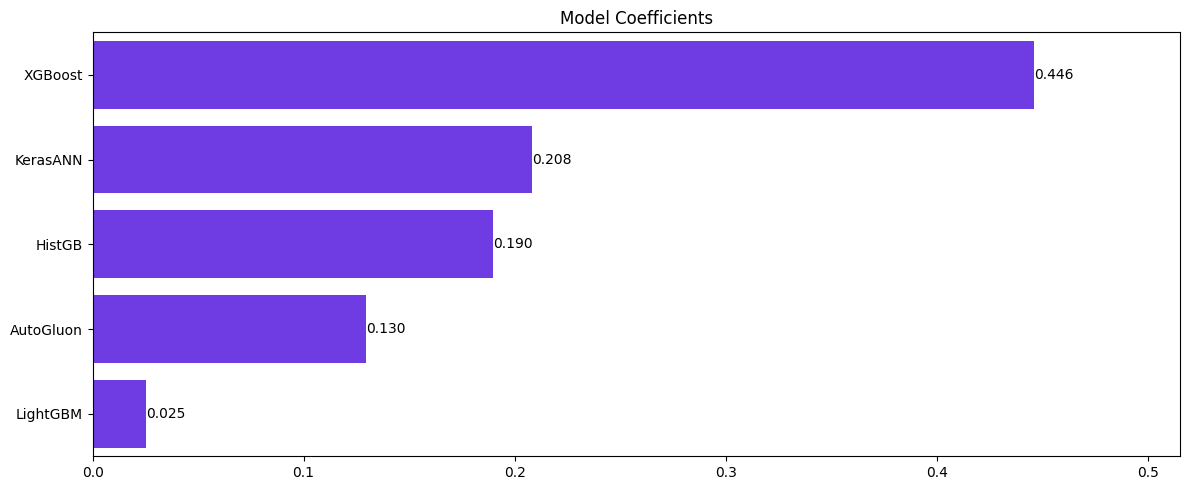

In [10]:
sorted_indices = np.argsort(np.abs(coeffs[0]))[::-1]
sorted_coeffs = np.array(coeffs[0])[sorted_indices]
sorted_model_names = np.array(list(oof_pred_probs.keys()))[sorted_indices]

plt.figure(figsize=(12, 5))
ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, color='#651FFF')

for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
    if value > 0:
        ax.text(value, i, f'{value:.3f}', va='center', ha='left', color='black')
    else:
        ax.text(value, i, f'{value:.3f}', va='center', ha='right', color='black')

xlim = ax.get_xlim()
ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))       
plt.title('Model Coefficients')
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Optimizing Threshold

In [11]:
def objective(trial):
    threshold = trial.suggest_float('threshold', 0, 1, step=0.001)
    y_preds = ensemble_oof_pred_probs[:, 1] >= threshold
    return matthews_corrcoef(y, y_preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2024-08-20 06:55:51,333] A new study created in memory with name: no-name-e450d8b2-c248-4913-ad62-13e998b4f74c
[I 2024-08-20 06:55:53,921] Trial 2 finished with value: 0.9835591771671226 and parameters: {'threshold': 0.779}. Best is trial 2 with value: 0.9835591771671226.
[I 2024-08-20 06:55:53,931] Trial 0 finished with value: 0.9761303137796981 and parameters: {'threshold': 0.08}. Best is trial 2 with value: 0.9835591771671226.
[I 2024-08-20 06:55:53,936] Trial 3 finished with value: 0.9796038362060275 and parameters: {'threshold': 0.908}. Best is trial 2 with value: 0.9835591771671226.
[I 2024-08-20 06:55:53,939] Trial 1 finished with value: 0.9849524010947234 and parameters: {'threshold': 0.497}. Best is trial 1 with value: 0.9849524010947234.
[I 2024-08-20 06:55:56,457] Trial 4 finished with value: 0.9833263635845529 and parameters: {'threshold': 0.795}. Best is trial 1 with value: 0.9849524010947234.
[I 2024-08-20 06:55:56,474] Trial 6 finished with value: 0.9838175523962795 a

In [12]:
study.best_params

{'threshold': 0.507}

In [13]:
trainer = Trainer(model, threshold=study.best_params['threshold'])
ensemble_scores, ensemble_oof_pred_probs, _ = trainer.fit_predict(X, y, X_test)
scores['Ensemble (tuned T)'] = ensemble_scores

Training Ensemble

--- Fold 1 - MCC: 0.984821
--- Fold 2 - MCC: 0.985266
--- Fold 3 - MCC: 0.984809
--- Fold 4 - MCC: 0.984930
--- Fold 5 - MCC: 0.985009

------ Average MCC: 0.984967 ± 0.000167


# Results

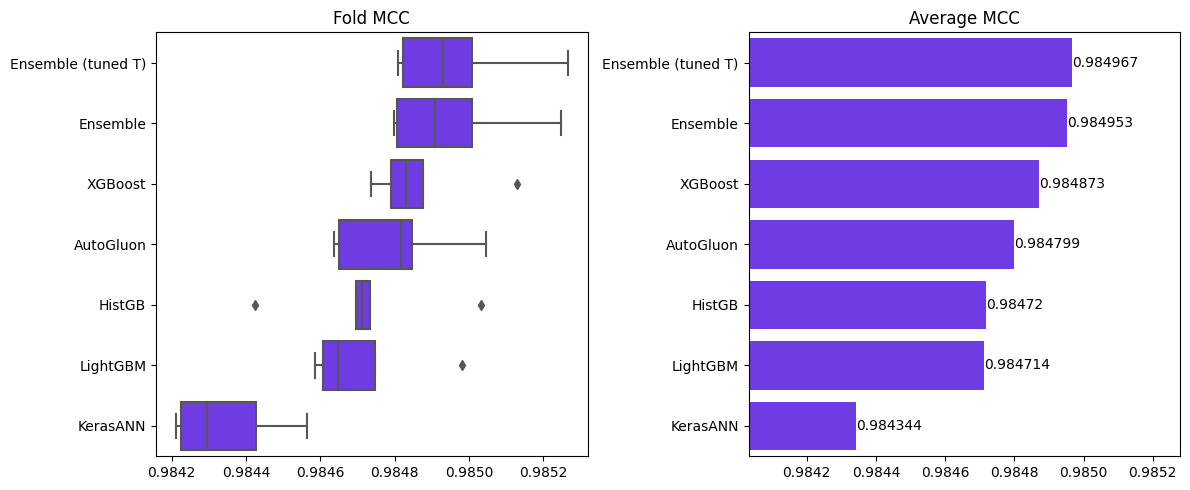

In [14]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', color='#651FFF')
axs[0].set_title('Fold MCC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color='#651FFF')
axs[1].set_title('Average MCC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()